In [495]:
#from __future__ import absolute_import
import pandas as pd
import pandas_profiling
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import json 

import google.auth
from google.oauth2 import service_account

#from google.cloud import bigquery, bigquery_storage_v1beta1

from bq_helper import BigQueryHelper

from google.cloud.bigquery import magics
%load_ext google.cloud.bigquery

google.cloud.bigquery.magics.context.use_bqstorage_api = True


The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Setting up BigQuery with Jupyter Notebook

### Google Cloud authentication

Set up Google Cloud authentication and download the json file with credentials.
[Documentation here](https://cloud.google.com/bigquery/docs/authentication/service-account-file)

Download large query results with 
the BigQuery Storage API by adding the --use_bq_storage_api argument to the %%bigquery magics.

[Documentation here](https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas)

### Configure the project ID 

Once you have [set up your account and your project on BigQuery](link), connect to the [public dataset](link) to start working.


### Load the Notebook magics

Jupyter has magic commands that make it easier to work with BigQuery; make sure to load them!

In [496]:
''' Set Google BigQuery project id and connect
'''

# Set key_path to the path to the service account key file.

key_path = "/Users/lorajohns/NYCTransit.json"

service_account_info = json.load(open(key_path))
credentials = service_account.Credentials.from_service_account_info(
    service_account_info)

#credentials2, your_project_id = google.auth.default(
#    scopes=["https://www.googleapis.com/auth/cloud-platform"]
#)


# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.

#credentials = service_account.Credentials.from_service_account_file(
#    key_path,
#    scopes=["https://www.googleapis.com/auth/cloud-platform"],
#)

project_id = 'nyc-transit-256016'

# Make clients.
client = bigquery.Client(
    credentials=credentials,
    #project=credentials.project_id,
    project=project_id,
)

#bqstorageclient = bigquery_storage_v1beta1.BigQueryStorageClient(
#    credentials=credentials
#)

#client = bigquery.Client(project=PROJECT_ID, location="US")
#dataset = client.create_dataset('example', exists_ok=True)

# magics.context.project = project_id

'''
Create a reference to the training data table 
Display head as dataframe
'''
#table = client.get_table()

#client.list_rows(table, max_results=5).to_dataframe()

'''
Cell magic:

Command: %%bigquery
Use: run a SQL query and return the results as a Pandas DataFrame
Note: Entire jupyter cell is treated as a SQL query; tab-complete disabled

'''


%reload_ext google.cloud.bigquery

#%load_ext google.cloud.bigquery

In [ ]:
''' 
# Download query results.
Run a query by using the query method. 
Call the to_dataframe method to wait for
the query to finish and download the results
by using the BigQuery Storage API.

'''
query_string = """
SELECT
CONCAT(
    'https://stackoverflow.com/questions/',
    CAST(id as STRING)) as url,
view_count
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE tags like '%google-bigquery%'
ORDER BY view_count DESC
"""

dataframe = (
    client.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
print(dataframe.head())

In [ ]:
'''Download all rows in a table by using the list_rows method, 
which returns a RowIterator object. Download rows by using the BigQuery
Storage API by calling the to_dataframe method with the bqstorage_client argument.
'''

# Download a table.
table = bigquery.TableReference.from_string(
    "bigquery-public-data.utility_us.country_code_iso"
)
rows = client.list_rows(
    table,
    selected_fields=[
        bigquery.SchemaField("country_name", "STRING"),
        bigquery.SchemaField("fips_code", "STRING"),
    ],
)
dataframe = rows.to_dataframe(bqstorage_client=bqstorageclient)
print(dataframe.head())

In [34]:
#bq_assistant = BigQueryHelper(project_id, "tlc_yellow_trips_2018")
# bq_assistant.list_tables()
# bq_assistant.head("global_air_quality", num_rows=3)
# bq_assistant.table_schema("global_air_quality")
# QUERY = "SELECT location, timestamp, pollutant FROM `bigquery-public-data.openaq.global_air_quality`"
# df = bq_assistant.query_to_pandas(QUERY)
# df = bq_assistant.query_to_pandas_safe(QUERY)

# Data Exploration and Cleaning

### Which relationships are interesting?


### Which data are inaccurate?

In [498]:
table = client.get_table('nyc_taxi.tlc_yellow_trips_2018')

In [69]:
samp = client.list_rows(table, max_results=10000).to_dataframe()

In [159]:
samp.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0        2.0 2018-03-16 23:38:24 2018-03-17 00:28:53                1   
1        2.0 2018-03-16 23:24:47 2018-03-17 00:12:19                1   
2        2.0 2018-03-16 23:12:14 2018-03-16 23:36:53                1   
3        2.0 2018-03-16 22:58:19 2018-03-16 23:43:51                1   
4        1.0 2018-03-16 22:24:25 2018-03-16 22:57:14                1   

  trip_distance rate_code store_and_fwd_flag payment_type fare_amount extra  \
0         10.68         1                  N            1          40   0.5   
1          8.02         1                  N            1          33   0.5   
2          8.36         1                  N            1          28   0.5   
3         20.06         1                  N            1        60.5   0.5   
4           9.9         1                  N            1          32   0.5   

  mta_tax tip_amount tolls_amount imp_surcharge total_amount  \
0     0.5       9.41         5.76           0.3        56.47   
1     0.5       8.01         5.76           0.3        48.07   
2     0.5       5.86            0           0.3        35.16   
3     0.5      16.89         5.76           0.3        84.45   
4     0.5       6.65            0           0.3        39.95   

  pickup_location_id dropoff_location_id  
0                186                 225  
1                230                 225  
2                 79                  42  
3                 97                 208  
4                238                  33

In [158]:
'''pandas reads BQ floats as Decimal, so get_table is not optimal 
better to use CAST(column AS FLOAT64) in explicit SQL'''

samp.trip_distance[0]

Decimal('10.68')

In [160]:
pandas_profiling.ProfileReport(samp)

In [110]:
'''I wrote this class as a utility when the client.query() 
function was failing due to some credential issues. '''

class DB:
    def __init__(self):
        self.string = ""
    
    def query(self, string):
        #if stored=True:
        return client.query(string).to_dataframe()

In [489]:
'''What are the longest and shortest rides, with fares?
Check out the deal on that trip halfway to the moon.
'''

sql = """
SELECT
    CAST(trip_distance AS FLOAT64) AS distance, CAST(total_amount AS FLOAT64) AS total
FROM `nyc_taxi.tlc_yellow_trips_2018`
ORDER BY trip_distance DESC
LIMIT 15;
"""

max_dist = client.query(sql).to_dataframe()

In [490]:
max_dist

distance    total
0   189483.84      4.0
1     7655.76  10001.3
2     6204.84  10000.3
3     6098.63  10000.3
4     5381.50  10001.3
5     4016.82  10000.3
6     2408.25   6023.8
7     2231.35   5581.3
8     2053.01   5134.8
9     1928.47   4824.3
10    1841.30   4606.3
11    1818.91   4551.3
12    1811.12   4530.8
13    1764.77   4414.8
14    1723.45   4311.8

In [502]:
sql = """
SELECT
    CAST(trip_distance AS FLOAT64) AS distance, CAST(total_amount AS FLOAT64) AS total
FROM `nyc_taxi.tlc_yellow_trips_2018`
ORDER BY trip_distance ASC
LIMIT 15;
"""

min_dist = client.query(sql).to_dataframe()

In [501]:
'''Oh boy, lots of zero-distance trips! I guess the taximeter was not engaged?
This will mess up our analysis, if we don't deal with it...
'''
min_dist

distance   total
0        0.0   12.40
1        0.0   29.60
2        0.0  103.74
3        0.0    9.30
4        0.0   78.36
5        0.0  126.96
6        0.0   50.88
7        0.0   21.60
8        0.0   58.30
9        0.0   14.50
10       0.0    4.12
11       0.0    3.96
12       0.0    7.30
13       0.0    3.79
14       0.0   55.44

In [506]:
'''Shall we find out how many zero-distance trips there are?

NB: I checked that "0 < x < 1" and "x < 1" and "x = 0" and "x < 0" were the same cases:

SELECT
    COUNT(CASE WHEN trip_distance > 0 AND trip_distance < 1 THEN 1 ELSE NULL END) AS zero_to_one,
    COUNT(CASE WHEN trip_distance < 1 THEN 1 ELSE NULL END) AS under_a_mile,
    COUNT(CASE WHEN trip_distance = 0 THEN 1 ELSE NULL END) AS equals_zero,
    COUNT(CASE WHEN trip_distance <= 0 THEN 1 ELSE NULL END) AS less_than_or_zero
    FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`;
    
Row | zero_to_one | under_a_mile | equals_zero | less_than_or_zero
1      28277346     29041353        764007         764007

'''


sql=("""SELECT
    COUNT(CASE WHEN trip_distance < 1 THEN 1 ELSE NULL END) AS under_a_mile,
    COUNT(CASE WHEN trip_distance <= 0 THEN 1 ELSE NULL END) AS zero_distance_trips
FROM `nyc_taxi.tlc_yellow_trips_2018`;""")

short = client.query(sql).to_dataframe()

In [507]:
short

under_a_mile  zero_distance_trips
0      29041353               764007

In [508]:
'''What are the fares?'''

sql = """
SELECT
    CAST(trip_distance AS FLOAT64) AS distance, CAST(tip_amount AS FLOAT64) AS tip, 
    CAST(total_amount AS FLOAT64) AS total
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance < 1
ORDER BY trip_distance DESC;
"""

zero_dist = client.query(sql).to_dataframe()

In [517]:
'''There are lots of problematic fares we need to get rid of.

THIS QUERY SHOULD BE RUN IN THE CLOUD. It's big. 
'''

sql = """
SELECT
    CAST(trip_distance AS FLOAT64) AS distance, CAST(tip_amount AS FLOAT64) AS tip, 
    CAST(total_amount AS FLOAT64) AS total
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance < 1
ORDER BY total, tip DESC
LIMIT 500;"""

bottom_outlier_fares = client.query(sql).to_dataframe()

In [518]:
bottom_outlier_fares

distance     tip   total
0        0.00    0.00 -800.30
1        0.00    0.00 -498.80
2        0.00    0.00 -498.80
3        0.01    0.00 -485.80
4        0.00    0.00 -475.30
5        0.00    0.00 -468.80
6        0.00    0.00 -465.30
7        0.23    0.00 -463.80
8        0.00    0.00 -460.30
9        0.00    0.00 -453.39
10       0.00    0.00 -450.30
11       0.00    0.00 -450.30
12       0.00    0.00 -450.30
13       0.00    0.00 -449.30
14       0.00    0.00 -449.30
15       0.11    0.00 -445.85
16       0.00    0.00 -430.30
17       0.61    0.00 -420.80
18       0.40    0.00 -415.80
19       0.00    0.00 -406.06
20       0.00    0.00 -400.80
21       0.00    0.00 -400.80
22       0.00    0.00 -400.30
23       0.00    0.00 -400.30
24       0.00    0.00 -400.30
25       0.00    0.00 -400.30
26       0.00 -322.42 -380.98
27       0.01    0.00 -374.80
28       0.01    0.00 -374.80
29       0.08    0.00 -370.30
..        ...     ...     ...
470      0.00    0.00  -93.80
471      0.02    0.00  -93.30
472      0.00    0.00  -93.10
473      0.00    0.00  -92.80
474      0.00    0.00  -92.80
475      0.39    0.00  -92.80
476      0.07    0.00  -92.30
477      0.05    0.00  -91.80
478      0.00    0.00  -91.69
479      0.00    0.00  -91.30
480      0.00    0.00  -91.30
481      0.00    0.00  -90.80
482      0.10    0.00  -90.80
483      0.76    0.00  -90.80
484      0.02    0.00  -90.80
485      0.15    0.00  -90.80
486      0.02    0.00  -90.80
487      0.00    0.00  -90.80
488      0.06    0.00  -90.80
489      0.50    0.00  -90.80
490      0.46    0.00  -90.80
491      0.00    0.00  -90.80
492      0.02    0.00  -90.80
493      0.00    0.00  -90.80
494      0.00    0.00  -90.80
495      0.43    0.00  -90.80
496      0.01    0.00  -90.80
497      0.00    0.00  -90.80
498      0.70    0.00  -90.80
499      0.00    0.00  -90.67

[500 rows x 3 columns]

In [535]:
sql1, sql2 = """SELECT
    CAST(trip_distance AS FLOAT64) AS distance, ROUND(MIN(tip_amount),4) AS min_tip, ROUND(AVG(tip_amount),4) 
    AS avg_tip, ROUND(MAX(tip_amount),4) AS max_tip
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance = 0
GROUP BY trip_distance
ORDER BY trip_distance;""", """SELECT
    CAST(trip_distance AS FLOAT64) AS distance, ROUND(MIN(total_amount),4) AS min_fare, ROUND(AVG(total_amount),4) 
    AS avg_fare, ROUND(MAX(total_amount),4) AS max_fare
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance = 0
GROUP BY trip_distance
ORDER BY trip_distance;"""

avg_tip_zero, avg_fare_zero = client.query(sql1).to_dataframe(), client.query(sql2).to_dataframe()

In [538]:
avg_tip_zero

distance  min_tip avg_tip max_tip
0       0.0  -322.42  2.8502     496

In [539]:
avg_fare_zero

distance min_fare avg_fare   max_fare
0       0.0   -800.3  29.4679  403408.18

In [540]:
sql = """
SELECT *
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE passenger_count = 0; 
"""

passenger_zero = client.query(sql).to_dataframe()

In [541]:
'''There are 1,003,298 trips with no passengers.'''

passenger_zero.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0         1 2018-07-02 12:31:25 2018-07-02 13:29:05                0   
1         1 2018-01-22 23:42:11 2018-01-22 23:58:26                0   
2         1 2018-03-27 15:13:05 2018-03-27 15:52:43                0   
3         1 2018-06-21 14:32:24 2018-06-21 14:34:12                0   
4         1 2018-12-17 15:51:02 2018-12-17 16:41:56                0   

  trip_distance rate_code store_and_fwd_flag payment_type fare_amount extra  \
0          14.9         1                  N            1          51     0   
1           7.1         1                  N            1        21.5   0.5   
2          10.4         1                  N            1          35     0   
3           0.1         1                  N            1           3     0   
4          11.9         1                  Y            1        39.5     0   

  mta_tax tip_amount tolls_amount imp_surcharge total_amount  \
0     0.5      10.35            0           0.3        62.15   
1     0.5       3.42            0           0.3        26.22   
2     0.5        8.3         5.76           0.3        49.86   
3     0.5       0.76            0           0.3         4.56   
4     0.5         14         5.76           0.3        60.06   

  pickup_location_id dropoff_location_id  
0                163                  31  
1                 88                 112  
2                264                 264  
3                161                 230  
4                100                 138

In [542]:
'''There's a lot of time issues to fix, too -- negative ride times cannot be accurate.

We have 40 negative rides and 85,644,984 zero-duration rides. Those won't be usable data.

SELECT 
COUNT(CASE WHEN DATETIME_DIFF(dropoff_datetime, pickup_datetime, HOUR) < 0 THEN 1 ELSE NULL END) AS negative,
COUNT(CASE WHEN DATETIME_DIFF(dropoff_datetime, pickup_datetime, HOUR) = 0 THEN 1 ELSE NULL END) AS zero

'''

sql = """
SELECT DATETIME_DIFF(dropoff_datetime, pickup_datetime, MINUTE) AS trip_time
FROM `nyc_taxi.tlc_yellow_trips_2018`
ORDER BY trip_time;
"""

trip_time = client.query(sql).to_dataframe()

In [113]:
db = DB()

df = db.query("""
SELECT
    trip_distance AS distance, total_amount AS total
FROM `nyc_taxi.tlc_yellow_trips_2018`
ORDER BY trip_distance DESC
LIMIT 5000;
""")
df

distance    total
0     189483.84        4
1       7655.76  10001.3
2       6204.84  10000.3
3       6098.63  10000.3
4        5381.5  10001.3
5       4016.82  10000.3
6       2408.25   6023.8
7       2231.35   5581.3
8       2053.01   5134.8
9       1928.47   4824.3
10       1841.3   4606.3
11      1818.91   4551.3
12      1811.12   4530.8
13      1764.77   4414.8
14      1723.45   4311.8
15      1459.31   3652.3
16       1402.1   3509.3
17      1297.35   3247.3
18       1061.2      8.8
19        943.5     14.3
20        932.9    14.75
21        910.8    300.3
22        833.1    23.15
23        831.7     11.8
24        830.8      9.1
25        801.4    12.35
26       753.66   1887.3
27        611.7     44.8
28          606    31.55
29        603.6    26.75
...         ...      ...
4970      50.34   297.67
4971      50.33   234.56
4972      50.33    144.3
4973      50.32   329.82
4974      50.32   165.82
4975      50.31   349.58
4976      50.31   249.06
4977       50.3    230.3
4978       50.3      3.8
4979       50.3      144
4980       50.3   256.26
4981       50.3    232.3
4982       50.3      274
4983       50.3   253.26
4984       50.3    182.3
4985       50.3   156.06
4986       50.3   220.06
4987       50.3   269.32
4988       50.3   375.37
4989       50.3    11.82
4990       50.3   196.27
4991       50.3   132.35
4992       50.3   232.06
4993       50.3   232.06
4994       50.3   209.56
4995       50.3    160.8
4996       50.3    129.8
4997       50.3   164.15
4998      50.28    165.3
4999      50.28   257.47

[5000 rows x 2 columns]

In [121]:
ten_k = db.query("""
SELECT total_amount, trip_distance
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE total_amount BETWEEN 10000 AND 11000
;

""")

In [122]:
ten_k

total_amount trip_distance
0      10000.3       6204.84
1      10001.3       7655.76
2      10000.3       6098.63
3      10001.3        5381.5
4      10000.3       4016.82
5     10005.72           258

In [114]:
'''I wrote this as a utility before I remembered that CAST(column AS INT64) 
in the SELECT statement would be more efficient!'''

def to_float(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: float(x))
        
to_float(total_amount, total_amount.columns)

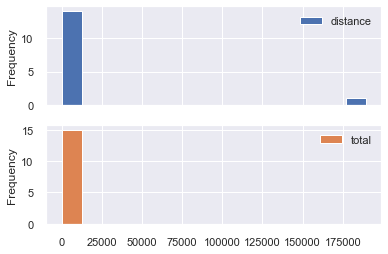

In [340]:
total_amount.plot(kind='hist',subplots=True, bins=15);

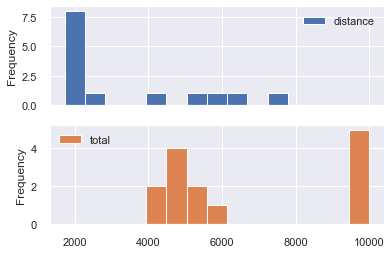

In [339]:
total_amount[(total_amount.distance < 8000) & (total_amount.total > 4)].plot(kind='hist',bins=15, subplots=True);

In [ ]:
price_per_mile = db.query("""
SELECT (total_amount/trip_distance) AS dollars_per_mile, trip_distance, total_amount
FROM `nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance > 0
ORDER BY dollars_per_mile DESC
""")

In [ ]:
price_per_mile

In [476]:
avg_dist_per_date = db.query("""SELECT 
  EXTRACT(MONTH FROM pickup_datetime) AS month,
  EXTRACT(DAY FROM pickup_datetime) AS day,
  EXTRACT(HOUR FROM pickup_datetime) AS hour,
  AVG(CAST(trip_distance AS FLOAT64)) AS avg_distance, AVG(CAST(fare_amount AS FLOAT64)) AS avg_fare, AVG(CAST(tip_amount AS FLOAT64)) AS avg_tip, AVG(CAST(total_amount AS FLOAT64)) AS avg_total, AVG(CAST(mta_tax AS FLOAT64)) AS avg_tax, AVG(CAST(tolls_amount AS FLOAT64)) AS avg_tolls
FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance BETWEEN 1 AND 2000 AND total_amount > 0
GROUP BY month, day, hour
ORDER BY month, day, hour
;""")

In [236]:
avg_dist_per_date.head()

month            1.000000
day              1.000000
hour             2.000000
avg_distance     3.109451
avg_fare        13.096146
avg_tip          1.642896
avg_total       16.183629
avg_tax          0.496234
avg_tolls        0.146663
dtype: float64

In [377]:
dates = {"Valentine's Day": (2, 14), "St. Patrick's Day": (3, 17), "Christmas Eve": (12, 24), "Christmas Day": (12, 15), "New Year's Day": (1,1), "July 4": (7, 4), "Labor Day": (9, 13), "Tues. after Labor Day": (9, 14), "Halloween 'Eve'": (10, 30), "Halloween": (10, 31)}
metrics = ['avg_distance','avg_fare','avg_tip','avg_total','avg_tax','avg_tolls']


def on_this_day(dates, metrics):
    '''
    input: dict of dates, list of dataframe columns to plot
    output: figure plotting individual dates of interest against the average day for 2018
    '''
    x = [x for x in range(24)]
    xi = [str(x) for x in range(24)]
    
    for i, metric in enumerate(metrics):
        plt.figure(i)
        for k,v in dates.items():
        # print(k,v[0],v[1])
        # print(avg_dist_per_date[(avg_dist_per_date.month == v[0]) & (avg_dist_per_date.day == v[1])].head(1))
            ax = avg_dist_per_date[(avg_dist_per_date.month == v[0]) & (avg_dist_per_date.day == v[1])].groupby(by=['month','day','hour']).mean()[metric].plot(figsize=(20,9))
            ax.legend(dates.keys())
            ax.set(xlabel='hour', ylabel=f'{metric}', title=f'{metric} of cab trips per hour on holidays')
        
        avg_dist_per_date.groupby('hour').mean()[metric].plot(figsize=(20,9), linestyle='dashed', legend='overall average')# why is the legend so annoying 
        plt.xticks(x, xi)
        plt.savefig(metric + '.png')  
    

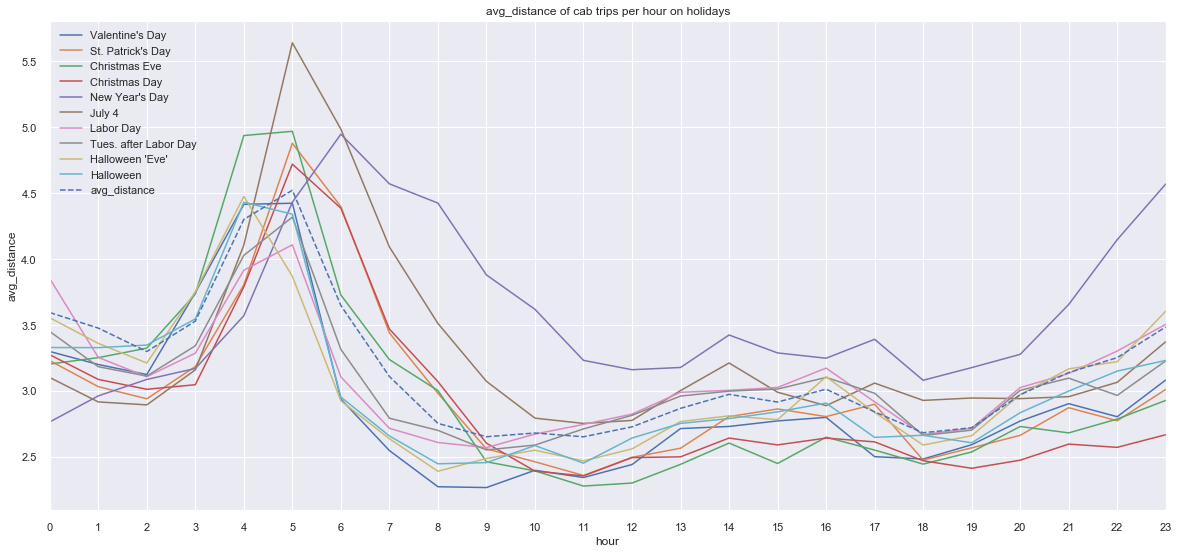

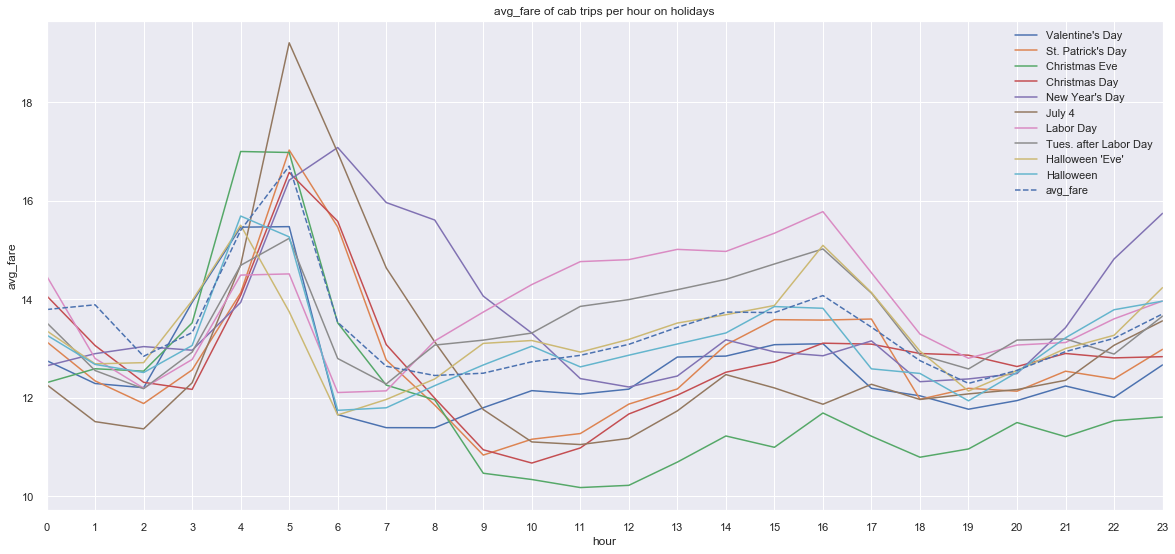

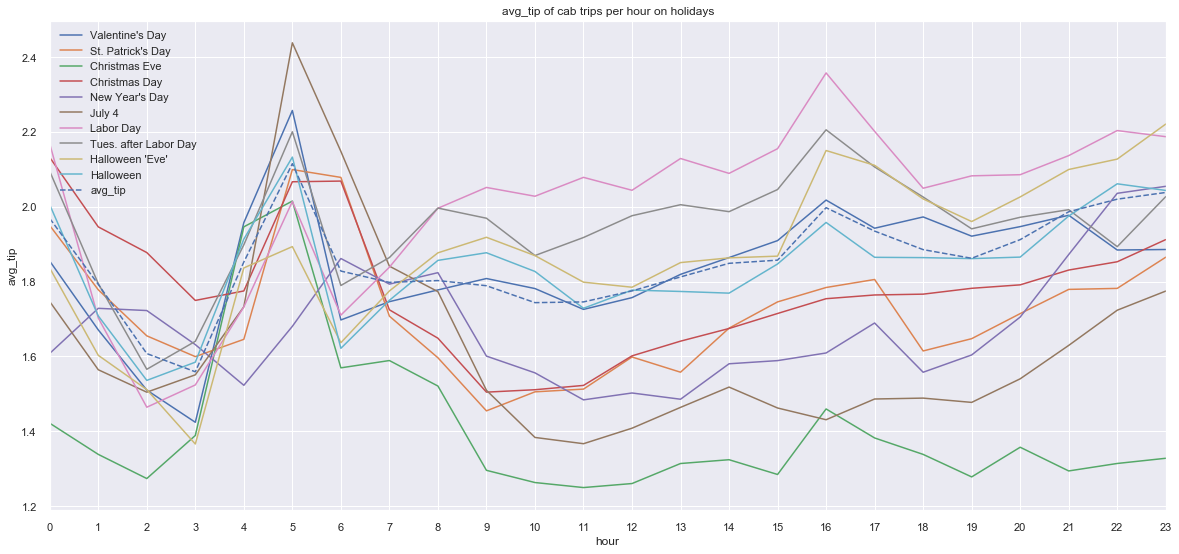

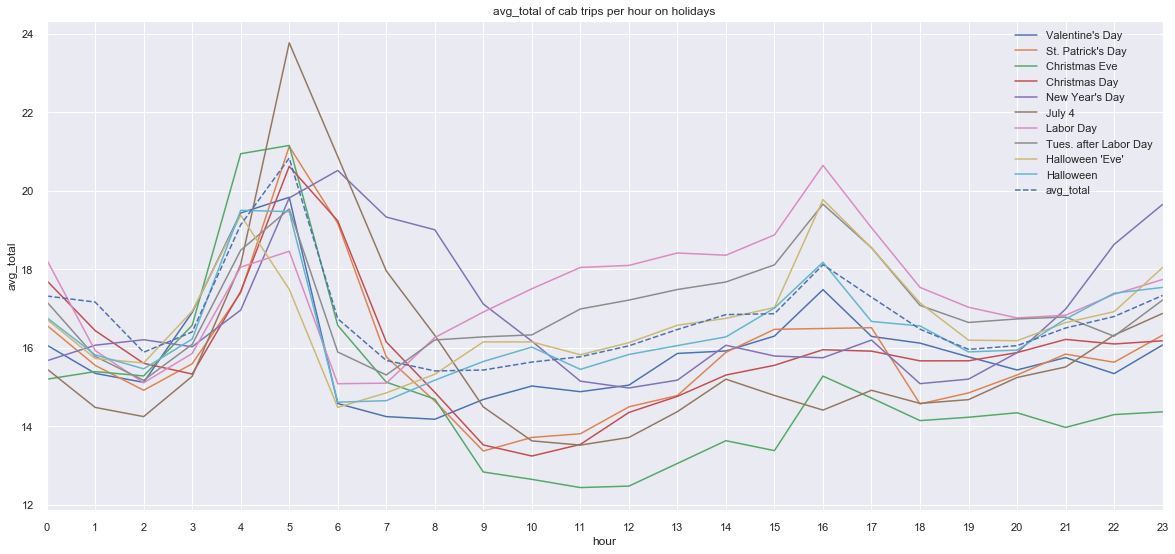

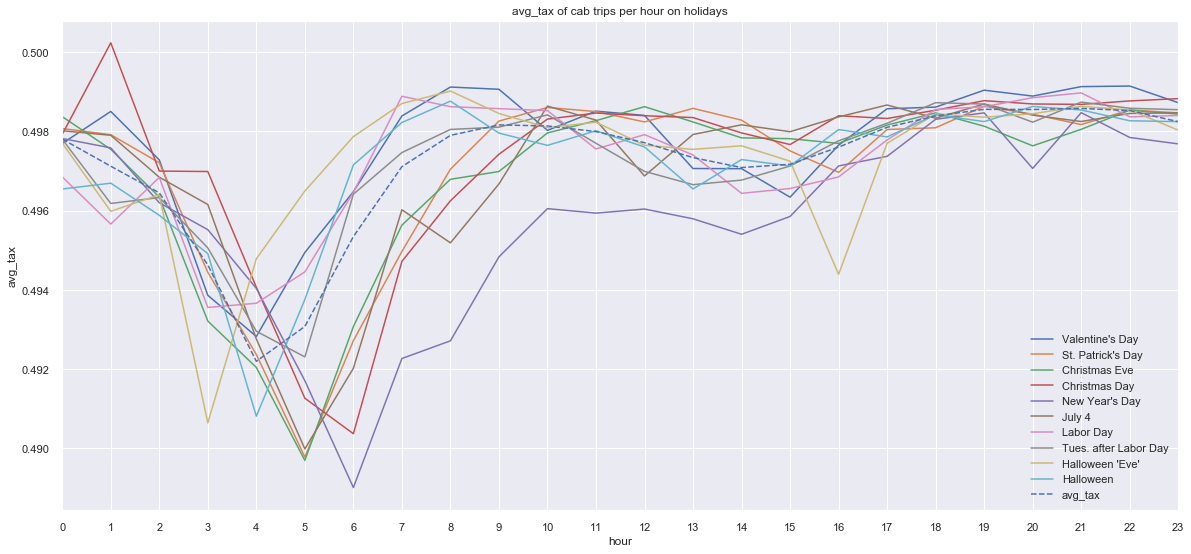

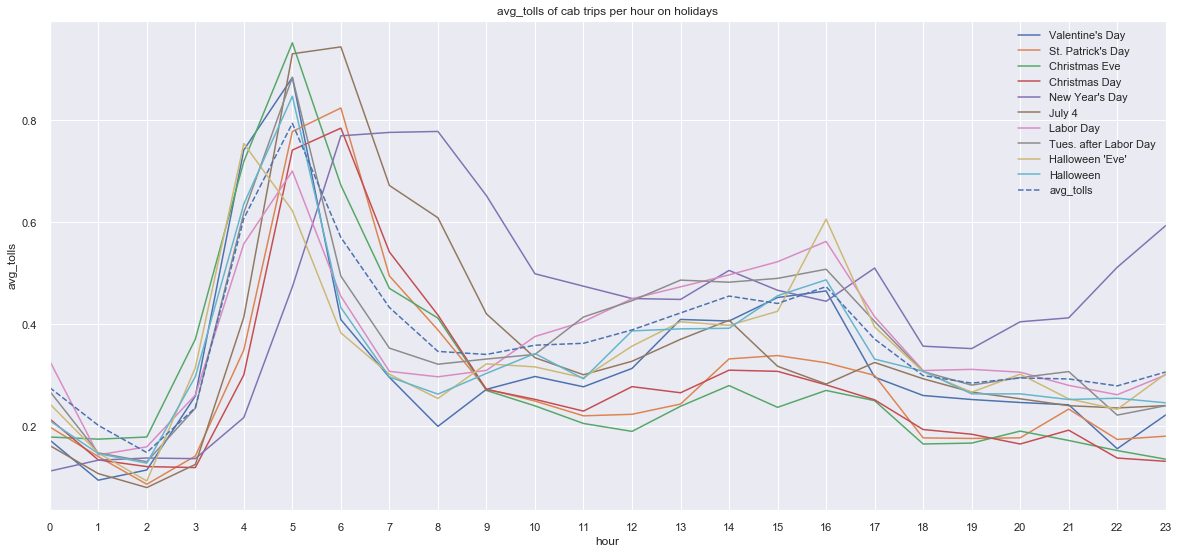

In [378]:
on_this_day(dates, metrics)

In [475]:
airport_rides = db.query("""SELECT 
  pickup_datetime, dropoff_datetime,
  CASE 
    WHEN rate_code = '2' THEN 'JFK'
    WHEN rate_code = '3' THEN 'Newark'
    WHEN rate_code = '4' THEN 'Nassau or Westchester' END AS airport_code,
    z1.zone_name AS pickup_zone, z2.zone_name AS dropoff_zone, dropoff_location_id, pickup_location_id, trip_distance, total_amount
FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`
LEFT JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` z1
ON pickup_location_id = z1.zone_id
LEFT JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` z2
ON dropoff_location_id = z2.zone_id
WHERE trip_distance BETWEEN 1 AND 2000 AND total_amount > 0 AND rate_code IN ('2', '3', '4')
;""")

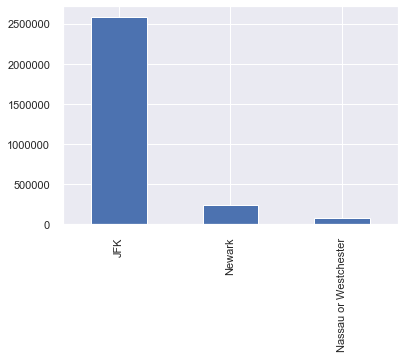

In [389]:
airport_rides['airport_code'].value_counts().plot(kind='bar');

In [442]:
jfk_rides = airport_rides[airport_rides.airport_code == 'JFK']

In [473]:
jfk_rides

pickup_datetime    dropoff_datetime airport_code  \
4       2018-03-02 10:39:02 2018-03-02 10:39:10          JFK   
126     2018-06-10 05:35:22 2018-06-10 05:35:50          JFK   
323     2018-09-03 14:28:57 2018-09-03 14:28:57          JFK   
355     2018-10-14 22:46:41 2018-10-14 23:18:01          JFK   
356     2018-04-12 07:09:55 2018-04-12 08:26:03          JFK   
357     2018-06-10 23:43:53 2018-06-11 00:09:07          JFK   
358     2018-06-10 16:57:31 2018-06-10 17:35:58          JFK   
359     2018-05-20 14:35:27 2018-05-20 15:29:09          JFK   
360     2018-11-15 07:31:31 2018-11-15 07:31:42          JFK   
361     2018-03-27 08:50:33 2018-03-27 08:50:48          JFK   
362     2018-04-30 13:11:32 2018-04-30 13:44:24          JFK   
363     2018-10-14 13:11:53 2018-10-14 13:52:56          JFK   
364     2018-12-07 21:41:27 2018-12-07 21:47:52          JFK   
365     2018-03-12 13:29:12 2018-03-12 14:18:05          JFK   
366     2018-05-01 05:44:13 2018-05-01 06:08:35          JFK   
367     2018-10-25 07:25:37 2018-10-25 08:40:53          JFK   
368     2018-10-25 02:34:23 2018-10-25 02:34:34          JFK   
369     2018-08-30 22:57:29 2018-08-30 23:33:41          JFK   
370     2018-02-11 10:10:39 2018-02-11 10:55:09          JFK   
371     2018-07-01 10:55:12 2018-07-01 11:24:21          JFK   
372     2018-01-23 07:16:05 2018-01-23 08:24:30          JFK   
373     2018-11-04 20:47:47 2018-11-04 21:22:30          JFK   
374     2018-05-20 06:50:28 2018-05-20 07:28:01          JFK   
375     2018-10-25 08:11:05 2018-10-25 09:56:00          JFK   
376     2018-02-11 14:34:44 2018-02-11 15:14:53          JFK   
377     2018-02-21 14:32:04 2018-02-21 15:21:09          JFK   
378     2018-07-25 19:49:23 2018-07-25 20:33:24          JFK   
379     2018-07-25 17:11:47 2018-07-25 18:24:25          JFK   
380     2018-10-03 16:15:28 2018-10-03 17:18:04          JFK   
381     2018-04-11 20:33:17 2018-04-11 21:16:07          JFK   
...                     ...                 ...          ...   
2884577 2018-01-26 02:45:52 2018-01-26 03:18:01          JFK   
2884578 2018-08-10 22:09:33 2018-08-10 22:09:37          JFK   
2884579 2018-10-29 17:44:34 2018-10-29 18:01:46          JFK   
2884580 2018-11-10 04:01:31 2018-11-10 04:01:39          JFK   
2884581 2018-01-16 20:10:42 2018-01-16 21:03:07          JFK   
2884582 2018-01-03 16:44:10 2018-01-03 17:24:52          JFK   
2884583 2018-04-14 03:03:45 2018-04-14 03:08:38          JFK   
2884584 2018-09-15 17:45:47 2018-09-15 18:20:44          JFK   
2884585 2018-03-18 06:13:52 2018-03-18 06:42:17          JFK   
2884586 2018-03-02 19:30:57 2018-03-02 19:31:06          JFK   
2884587 2018-11-16 00:42:35 2018-11-16 01:02:00          JFK   
2884588 2018-01-13 01:27:40 2018-01-13 01:27:45          JFK   
2884589 2018-10-27 01:49:44 2018-10-27 01:50:04          JFK   
2884590 2018-08-31 17:10:32 2018-08-31 18:39:32          JFK   
2884591 2018-11-16 00:07:49 2018-11-16 01:11:03          JFK   
2884592 2018-08-20 20:30:29 2018-08-20 21:30:40          JFK   
2884593 2018-10-15 09:26:59 2018-10-15 09:27:09          JFK   
2884594 2018-06-01 20:09:53 2018-06-01 20:38:33          JFK   
2884595 2018-06-11 13:41:09 2018-06-11 13:41:30          JFK   
2884598 2018-11-07 04:11:31 2018-11-07 04:11:41          JFK   
2884599 2018-10-16 21:12:56 2018-10-16 21:13:13          JFK   
2884600 2018-07-02 22:59:51 2018-07-02 23:29:54          JFK   
2884601 2018-11-12 15:37:36 2018-11-12 15:38:18          JFK   
2884602 2018-11-27 04:59:07 2018-11-27 04:59:12          JFK   
2884603 2018-04-17 21:11:32 2018-04-17 21:11:35          JFK   
2884604 2018-07-08 03:47:48 2018-07-08 04:13:08          JFK   
2884605 2018-01-11 19:42:41 2018-01-11 19:57:18          JFK   
2884606 2018-03-25 12:52:21 2018-03-25 12:52:22          JFK   
2884607 2018-05-05 00:44:39 2018-05-05 00:45:03          JFK   
2884608 2018-04-04 00:33:22 2018-04-04 00:35:18          JFK   

                           pickup_zone     

In [ ]:
std_per_hour = db.query("""
SELECT 
  EXTRACT(MONTH FROM pickup_datetime) AS month,
  EXTRACT(DAY FROM pickup_datetime) AS day,
  EXTRACT(HOUR FROM pickup_datetime) AS hour,
  STDDEV(trip_distance) AS STD_distance, STDDEV(fare_amount) AS STD_fare, STDDEV(tip_amount) AS STD_tip, STDDEV(total_amount) AS STD_total, STDDEV(mta_tax) AS STD_tax, STDDEV(tolls_amount) AS STD_tolls
FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance BETWEEN 0 AND 2000 AND total_amount > 0
GROUP BY month, day, hour
ORDER BY month, day, hour
;
""")

# Feature engineering and model creation

## Airport rides, datetime parts, weekday names, and one-hot encoded weekends

In [547]:
sql = ("""SELECT p.zone_name as pzone, d.zone_name as dzone, CASE WHEN rate_code in ('2', '3') 
OR pickup_location_id IN ("1", "132", "138") 
OR dropoff_location_id IN ("1", "132", "138") THEN 1 ELSE 0 END AS is_airport 
FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018` 
INNER JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` p
ON pickup_location_id = p.zone_id
INNER JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` d
ON dropoff_location_id = d.zone_id
LIMIT 1000;""")

client.query(sql).to_dataframe()

pzone                           dzone  is_airport
0            Upper West Side South          West Farms/Bronx River           0
1        Times Sq/Theatre District                  Yorkville East           0
2                  Lower East Side                    Clinton East           0
3        Times Sq/Theatre District                        Woodside           0
4                     Clinton East      Spuyten Duyvil/Kingsbridge           0
5        Times Sq/Theatre District                     Boerum Hill           0
6                LaGuardia Airport  Long Island City/Hunters Point           1
7            Upper East Side South            TriBeCa/Civic Center           0
8                LaGuardia Airport                   Midtown North           1
9                LaGuardia Airport               Battery Park City           1
10               LaGuardia Airport             Lincoln Square West           1
11                     JFK Airport              South Williamsburg           1
12                    Clinton West               Battery Park City           0
13   Sutton Place/Turtle Bay North                  Newark Airport           1
14             Lincoln Square East        Washington Heights North           0
15               LaGuardia Airport           Upper East Side South           1
16                        Kips Bay                      Park Slope           0
17               LaGuardia Airport                   Midtown South           1
18               LaGuardia Airport       Williamsburg (North Side)           1
19               LaGuardia Airport   Sutton Place/Turtle Bay North           1
20               Battery Park City                    Midtown East           0
21           Upper West Side North               LaGuardia Airport           1
22               Battery Park City                  Central Harlem           0
23               LaGuardia Airport                 Lower East Side           1
24               LaGuardia Airport            Flatbush/Ditmas Park           1
25               LaGuardia Airport         Two Bridges/Seward Park           1
26               LaGuardia Airport       Times Sq/Theatre District           1
27               LaGuardia Airport                Brooklyn Heights           1
28                 Lenox Hill West       Williamsburg (South Side)           0
29                   Midtown North               LaGuardia Airport           1
..                             ...                             ...         ...
970            UN/Turtle Bay South              World Trade Center           0
971   Penn Station/Madison Sq West               East Harlem South           0
972              LaGuardia Airport                    Central Park           1
973              LaGuardia Airport                     Murray Hill           1
974              Battery Park City                    Midtown East           0
975              LaGuardia Airport           Upper East Side North           1
976                  Midtown South                      Park Slope           0
977          Upper East Side North        Washington Heights South           0
978                   Clinton East        Washington Heights North           0
979          Upper West Side North           Upper West Side North           0
980                   East Village               LaGuardia Airport           1
981                    JFK Airport                    Forest Hills           1
982                   Midtown East                Brooklyn Heights           0
983                  Midtown North               LaGuardia Airport           1
984              LaGuardia Airport           Upper East Side South           1
985                   East Chelsea        Washington Heights South           0
986              LaGuardia Airport           Upper West Side South           1
987                       Union Sq                Prospect Heights           0
988              LaGuardia Airport       Times Sq/Theatre District           1


In [ ]:
'''query to return averages per unit of time, to the hour'''

avgs_per_hour = db.query("""SELECT 
  EXTRACT(MONTH FROM pickup_datetime) AS month,
  EXTRACT(DAY FROM pickup_datetime) AS day,
  EXTRACT(HOUR FROM pickup_datetime) AS hour,
  CAST(trip_distance AS FLOAT64) AS distance, CAST(fare_amount AS FLOAT64) AS fare, CAST(tip_amount AS FLOAT64) AS avg_tip, CAST(total_amount AS FLOAT64) AS total, CAST(mta_tax AS FLOAT64) AS avg_tax, CAST(tolls_amount AS FLOAT64) AS tolls
FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`
WHERE trip_distance BETWEEN 0 AND 2000 AND total_amount > 0
GROUP BY month, day, hour
ORDER BY month, day, hour
;""")

In [ ]:
'''query to return averages per zone per unit of time, to the hour'''

avgs_per_zone = db.query("""SELECT 
  EXTRACT(MONTH FROM pickup_datetime) AS month,
  EXTRACT(DAY FROM pickup_datetime) AS day,
  EXTRACT(HOUR FROM pickup_datetime) AS hour,
  pickup_location_id, z1.zone_name AS pickup_zone, dropoff_location_id, z2.zone_name AS dropoff_zone,
  AVG(CAST(trip_distance AS FLOAT64)) AS avg_distance, AVG(CAST(fare_amount AS FLOAT64)) AS avg_fare, AVG(CAST(tip_amount AS FLOAT64)) AS avg_tip, AVG(CAST(total_amount AS FLOAT64)) AS avg_total, AVG(CAST(mta_tax AS FLOAT64)) AS avg_tax, AVG(CAST(tolls_amount AS FLOAT64)) AS avg_tolls
FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`
LEFT JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` z1
ON pickup_location_id = z1.zone_id
LEFT JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` z2
ON dropoff_location_id = z2.zone_id
WHERE trip_distance BETWEEN 0 AND 2000 AND total_amount > 0
GROUP BY month, day, hour, pickup_location_id, pickup_zone, dropoff_location_id, dropoff_zone
ORDER BY month, day, hour
;""")

In [ ]:
'''query broken down with ordinal weekday categories'''

info_weekdays = db.query("""
WITH weekdays AS (SELECT ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'] AS dayarray),

trip_data AS (SELECT
   pickup_datetime, dropoff_datetime, dayarray[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS day_of_week,
   trip_distance, total_amount, tip_amount, p.zone_id AS pickup_zone, d.zone_id AS dropoff_zone, p.borough AS pickup_borough, 
   d.borough AS dropoff_borough, p.zone_geom AS pickup_coord, d.zone_geom AS dropoff_coord, payment_type,
   pickup_location_id, dropoff_location_id, rate_code

FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`, weekdays
JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` p
ON pickup_location_id = p.zone_id
JOIN  `nyc-transit-256016.nyc_taxi.taxi_zone_geom` d
ON dropoff_location_id = d.zone_id
WHERE total_amount BETWEEN 0 AND 10000)

SELECT * FROM trip_data;""")

In [474]:
weekday_df = db.query("""WITH weekdays AS (SELECT ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'] AS dayarray),

trip_data AS (SELECT
   pickup_datetime, dropoff_datetime, dayarray[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS day_of_week,
   trip_distance, total_amount, tip_amount, p.zone_id AS pickup_zone, d.zone_id AS dropoff_zone, p.borough AS pickup_borough, 
   d.borough AS dropoff_borough, p.zone_geom AS pickup_coord, d.zone_geom AS dropoff_coord, payment_type,
   pickup_location_id, dropoff_location_id, rate_code,
   CASE WHEN EXTRACT(DAYOFWEEK FROM pickup_datetime) IN (1,7) THEN 1 ELSE 0 END AS is_weekend,
   CASE WHEN p.zone_id = d.zone_id THEN 1 ELSE 0 END AS same_borough_trip

FROM `nyc-transit-256016.nyc_taxi.tlc_yellow_trips_2018`, weekdays
JOIN `nyc-transit-256016.nyc_taxi.taxi_zone_geom` p
ON pickup_location_id = p.zone_id
JOIN  `nyc-transit-256016.nyc_taxi.taxi_zone_geom` d
ON dropoff_location_id = d.zone_id
WHERE total_amount BETWEEN 0 AND 10000 AND trip_distance > 0)

SELECT * FROM trip_data
LIMIT 16000;""")